In [5]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import csv
#import pandasql as ps
import matplotlib.pyplot as plt
#import shapefile as shp
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
#import pysal as ps
import scipy

#import torch
#import torch.nn as nn
#import torch.nn.parallel
#import torch.optim as optim
#import torch.utils.data

#from torch.nn import functional
#from torch.autograd import Variable

import statistics

#temporal pattern clustering
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from sklearn import metrics
from scipy.cluster.hierarchy import fcluster
from scipy.stats import chisquare
from scipy.stats import wasserstein_distance

#regression model
from patsy import dmatrices
#import statsmodels.api as sm

from datetime import datetime

#from pysal.model import spreg
#from pysal.lib import weights
#from pysal.explore import esda

#calculate the demographic bias 
#use wasserstein_distance
from scipy.stats import wasserstein_distance

#path = 'C:/Users/29700/Downloads/RecSys-Workshop/tutorials/'
#os.chdir(path)
#import utilities as utl

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from datetime import datetime
import time
from sklearn.decomposition import NMF

import time
import scipy.sparse
from scipy.stats import entropy
from sys import exit

import itertools
from itertools import permutations

import xml.etree.ElementTree as ET

import geopandas as gpd

In [6]:
path = "G:/My Drive/2021/Bias/sumo_simulation/appsim"
os.chdir(path)
#os.listdir()

In [7]:
#read app-based data
csv_path = '../data-1670309862526.csv'
fcd_dt_path = 'fcd_data_5.csv'
savepath = 'origin_dt.csv'

def get_time_variationbyzone(data, taz, time_loc, plot_index):
    data_taz = data[data['taz']==taz]
    data_taz = data_taz.sort_values(by=['hr', 'min'])
    data_taz = data_taz.groupby(by=['hr', 'min']).sum()
    
    data_taz.reset_index(inplace=True)
    data_taz = data_taz[['hr','min','sum']]
    #data_taz
    obs_sum = np.zeros((len(time_loc)))
    hr_ = data_taz['hr'].values
    min_ = data_taz['min'].values
    sum_val = data_taz['sum'].values
    
    for i in range(len(hr_)):
        obs_sum[time_loc[str(hr_[i])+'_'+str(min_[i])]] = sum_val[i]
    #use obs/max(obs) instead of obs/sum(obs) 
    obs_per = obs_sum/(np.max(obs_sum))
    
    if plot_index == True:
        fig = plt.figure(taz)
        plt.plot(obs_sum)
    return(obs_per)

def get_sim_obs_ts(fcd_out, taz_time_per, avg_per, return_sim=True):
    taz_ = fcd_out['taz'].values
    time_5 = fcd_out['time_5'].values
    per_ts = []
    for i in range(len(taz_)):
        if taz_[i] in taz_time_per:
            per_ts.append(taz_time_per[taz_[i]][time_5[i]])
        else:
            per_ts.append(avg_per[time_5[i]])
    if return_sim == True:
        sim_obs_ts = [] 
        for i in range(len(per_ts)):
            sim_obs_ts.append(np.random.binomial(1, per_ts[i], 1)[0])
        return(sim_obs_ts)
    else:
        return(per_ts)
    
def get_simdt(fcd_out, sim_col, newuser_, loc_time):
    sim_dt = np.zeros((len(newuser_), len(loc_time)))
    ids_ = fcd_out['id'].values
    tl_id_ = fcd_out['tl_id'].values
    ct_ = fcd_out[sim_col].values
    for i in range(len(ids_)):
        sim_dt[newuser_[ids_[i]]][loc_time[tl_id_[i]]] = ct_[i]
    return(sim_dt)


#convert dt to matrix
def getfcdnorigindt(fcd_dt_path, savepath, 
                    data_obs, time_loc, taz_time_per, avg_per, 
                    save_index):
    fcd_out = pd.read_csv(fcd_dt_path, header=None)
    fcd_out.columns = ['id', 'taz', 'time']
    fcd_out.taz = fcd_out.taz.astype('int')
    fcd_out.time = fcd_out.time.astype('int')
    print('num id', len(np.unique(fcd_out.id)))

    #fcd_out.sort_values(by=['time', 'taz'])
    fcd_out['tl_id'] = fcd_out['taz'].astype(str)+'_'+((fcd_out['time']/300).astype(int)).astype(str)

    fcd_out = fcd_out[~fcd_out['time'].isin([86400, 86700])]
    time_ = np.unique((fcd_out['time']/300).astype(int))
    newuser_ = {}
    index_ = 0
    for i in np.unique(fcd_out.id):
        newuser_[i] = index_
        index_ += 1    
    ## fcd output processing
    #delete the data exceeds the 24-hr daily period
    fcd_out = fcd_out[~fcd_out['time'].isin([86400, 86700])]
    fcd_out.taz = fcd_out.taz.astype('int')
    fcd_out.time = fcd_out.time.astype('int')
    fcd_out['time_5'] = fcd_out.time/300

    fcd_out.time_5 = fcd_out.time_5.astype('int')

    obs = data_obs.groupby(by=['time']).size().values
    obs_per = obs/max(obs)

    sample_ct = lambda x: np.random.binomial(1, obs_per[x], 1)[0]

    fcd_out['sim_obs'] = fcd_out['time_5'].apply(sample_ct)

    fcd_out['tl_id'] = fcd_out['taz'].astype(str)+'_'+((fcd_out['time']/300).astype(int)).astype(str)
    
    sim_obs = get_sim_obs_ts(fcd_out, taz_time_per, avg_per, True)
    fcd_out['sim_obs_ts'] = sim_obs

    #simulated observations based on time variation
    print('sim based on time', 
          np.count_nonzero(fcd_out['sim_obs'])/fcd_out.shape[0])

    #simulated observations based on time and spatial variation
    print('sim based on time and spatial',
          np.count_nonzero(fcd_out['sim_obs_ts'])/fcd_out.shape[0])
    
    return(fcd_out)


def run_sim(csv_path, fcd_dt_path, savepath, save_index=False, plot_index=True):
    data_obs = pd.read_csv(csv_path, header=0)
    print('app based data', data_obs.head(3))
    
    newids = np.unique(data_obs.newid)
    newid_ = {}
    index_ = 0
    for i in range(len(newids)):
        newid_[newids[i]] = index_
        index_ += 1
        
    get_hr = lambda x: x.split(':')[0]
    get_min = lambda x: x.split(':')[1]

    hr_ = np.unique(data_obs['time'].astype(str).apply(get_hr).astype(int))
    min_ = np.unique(data_obs['time'].astype(str).apply(get_min).astype(int))
    taz_ = np.unique(data_obs['taz'])

    data_obs['hr'] = data_obs['time'].astype(str).apply(get_hr).astype(int)
    data_obs['min'] = data_obs['time'].astype(str).apply(get_min).astype(int)
    
    index_ = 0
    lt_loc = {}
    for taz in taz_:
        for h in hr_:
            for m in min_:
                lt_loc['4_'+str(h)+'_'+str(m)+'_'+str(taz)] = index_
                index_ += 1
    obs_mx = np.zeros((len(newid_), len(lt_loc)))

    newid_col = data_obs.newid.values
    key_col = data_obs.key.values
    ct_col = data_obs['sum'].values

    for i in range(len(newid_col)):
        obs_mx[newid_[newid_col[i]]][lt_loc[key_col[i]]] = 1

    total_ct = np.sum(obs_mx, axis=0)
    #get ct based on taz and time
    total_ct = total_ct.reshape(1, total_ct.shape[0])
    total_ct_conver = np.hsplit(total_ct, len(taz_))
    max_num = np.max(np.array(total_ct_conver), axis=2)
    
    if plot_index == True:
        plt.plot(data_obs.groupby(by=['time']).size().values)
        
    time_loc = {}
    index_ = 0
    for hr in hr_:
        for miuts in min_:
            time_loc[str(hr)+'_'+str(miuts)] = index_
            index_ += 1

    taz_time_per = {}
    avg_per = 0
    index_ = 0 
    for taz_id in taz_:
        taz_time_per[taz_id] = get_time_variationbyzone(data_obs, taz_id, time_loc, plot_index)
        if index_ == 0:
            avg_per = taz_time_per[taz_id]
        else:
            avg_per = avg_per + taz_time_per[taz_id]
        index_ += 1
        
    avg_per = avg_per/np.max(avg_per)
    if plot_index == True:
        fig = plt.figure(1)
        plt.plot(avg_per)
        
    fcd_out = getfcdnorigindt(fcd_dt_path, savepath, data_obs, time_loc, taz_time_per, avg_per, save_index=False)
    
    fcd_out['obs'] = 1
    #simulation compare
    print('sim_t vs sim_ts', mean_squared_error(fcd_out.sim_obs, fcd_out.sim_obs_ts, squared=False))
    print('obs vs sim_ts', mean_squared_error(fcd_out.obs, fcd_out.sim_obs_ts, squared=False))
    print('obs vs sim_t', mean_squared_error(fcd_out.obs, fcd_out.sim_obs, squared=False))
    
    return(fcd_out)    

In [7]:
csv_path = '../data-1670309862526.csv'
fcd_dt_path = 'fcd_data_5.csv'
savepath = 'origin_dt.csv'

fcd_out = run_sim(csv_path, fcd_dt_path, savepath, save_index=False, plot_index=False)
fcd_out.head(3)

app based data    newid  sum         key  taz  date  time
0     26    1  4_3_55_608  608     4  3:55
1     26    2   4_4_5_615  615     4  4:05
2     26    1  4_3_40_578  578     4  3:40
num id 60728
sim based on time 0.429029131830937
sim based on time and spatial 0.3605606503312408
sim_t vs sim_ts 0.7061498099026265
obs vs sim_ts 0.799649516768915
obs vs sim_t 0.7556261431217577


id  taz  time  tl_id  time_5  sim_obs  sim_obs_ts  obs
0    10_41979657  506     0  506_0       0        0           0    1
1    13_49194874  440     0  440_0       0        1           0    1
2  21_47580428_0  630     0  630_0       0        0           1    1

In [14]:
origin_dt.newid

0             26
1             26
2             26
3             26
4             32
           ...  
227191    458481
227192    458481
227193    458481
227194    458481
227195    458481
Name: newid, Length: 227196, dtype: int64

In [148]:
def get_timeloc(num_taz, time_interval, t):
    select_time_loc = []
    for i in range(num_taz):
        select_time_loc.append(time_interval*i+t)
    return(select_time_loc)

def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def convert_timedic2mx(time_dict):
    #dataDict = {'device1':(1,1,0,1), 'device2':(0,1,0,1), 'device3':(1,0,0,1)}
    #orderedNames = ['device1','device2','device3']
    times = list(time_dict.keys())
    dataMatrix = np.array([time_dict[i] for i in times])
    return(dataMatrix)

def get_missing_rate(time_index_mx, input_mx_indi):
    indi_m = input_mx_indi[time_index_mx]
    return(np.count_nonzero(np.sum(indi_m,axis=1))/(indi_m.shape[0]))

def check_missings(input_mx, time_interval, plot_idx=True):
    num_taz = int(input_mx.shape[1]/time_interval)
    #print('num taz', num_taz)
    time_dic = get_pred_timedict(num_taz, time_interval)
    time_mx = convert_timedic2mx(time_dic)
    missing_rate = []
    for i in range(input_mx.shape[0]):
        missing_rate.append(get_missing_rate(time_mx, input_mx[i,]))
        #print(missing_rate)
    if plot_idx == True:
        plt.hist(missing_rate)
        plt.title('hist of non-missing rate')
        plt.xlabel('non-missing rate')
        plt.ylabel('# of ids')
        print(max(missing_rate))
        print(min(missing_rate))
    return(np.array(missing_rate))

In [74]:
int(origin_mx.shape[1]/288)


167

In [92]:
#del(origin_dt)
origin_mx[0,][time_mx].shape

(288, 167)

In [113]:
282/288

0.9791666666666666

In [112]:
np.count_nonzero(np.sum(origin_mx[7978,][time_mx], axis=1))

282

In [115]:
np.count_nonzero(origin_mx[7978, ][time_mx], axis=1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1,
       2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

In [81]:
get_missing_rate(time_mx, origin_mx[,])

0.010416666666666666

In [80]:
time_mx = convert_timedic2mx(get_pred_timedict(167, 288))

In [50]:
#read original data
origin_dt = pd.read_csv(csv_path)
origin_dt.head(3)
get_hr = lambda x: x.split(':')[0]
get_minus = lambda x: x.split(':')[1]

origin_dt['hr'] = origin_dt['time'].apply(get_hr)
origin_dt['minus'] = origin_dt['time'].apply(get_minus)
origin_dt['hr'] = origin_dt['hr'].astype(int)
origin_dt['minus'] = origin_dt['minus'].astype(int)
origin_dt.sort_values(by=['newid','hr','minus','taz'])

taz_idx = {}
idx = 0
for i in np.unique((origin_dt.sort_values(by=['taz'])).taz):
    taz_idx[i] = idx
    idx += 1

get_taz_idx = lambda x: taz_idx[x]
origin_dt['tazidx'] = origin_dt['taz'].apply(get_taz_idx)
origin_dt['ts_idx'] = origin_dt['tazidx']*288+origin_dt['hr']*12+origin_dt['minus']/5
origin_dt['ts_idx'] = origin_dt['ts_idx'].astype(int)

user_idx = {}
idx = 0
for i in np.unique(origin_dt.newid):
    user_idx[i] = idx
    idx += 1

num_taz = len(np.unique(origin_dt['taz']))
num_time = 288
col = int(num_taz*num_time)
    
origin_mx = np.zeros((len(user_idx), col))
for i in range(origin_dt.shape[0]):
    origin_mx[user_idx[origin_dt.newid[i]], origin_dt.ts_idx[i]] = 1

In [65]:
idx_user = {}
for i in user_idx.values():
    idx_user[i] = list(user_idx.keys())[i]

In [120]:
len(missing_info)

13709

In [121]:
len(np.where(missing_info<=0.1)[0])/len(missing_info)

0.8629367568750456

In [123]:
len(np.where(missing_info>0.1)[0])/len(missing_info)

0.1370632431249544

0.9791666666666666
0.003472222222222222


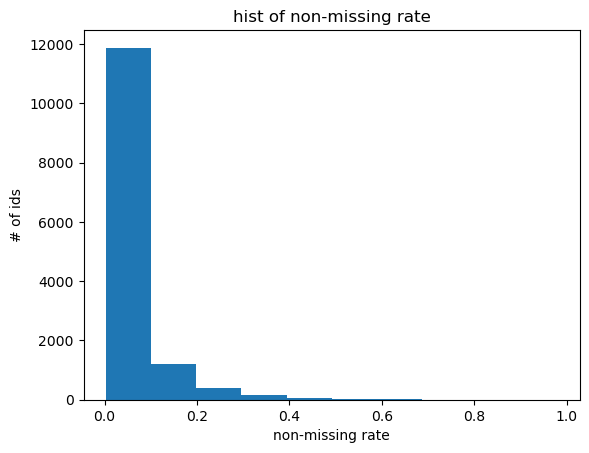

In [149]:
missing_info = check_missings(origin_mx, 288, plot_idx=True)

array([  237,   399,   650,   652,   664,   806,  1593,  2692,  2733,
        3201,  3361,  3626,  3637,  4081,  5137,  5782,  6142,  6303,
        7604,  7674,  7978,  8188,  8852,  9462,  9915, 10180, 11108,
       11177, 11410, 11889, 13198, 13207, 13431], dtype=int64)

In [136]:
users = np.array(list(user_idx.keys()))

In [138]:
origin_dt[['']users[np.where(missing_info>0.5)[0]]]

array([  7778,  13169,  21463,  21664,  22126,  27197,  53848,  89524,
        91287, 107038, 113356, 120879, 121391, 138328, 174781, 196022,
       207796, 212811, 254988, 257002, 266855, 275082, 296588, 316250,
       332458, 340567, 371894, 374443, 382693, 399424, 442000, 442276,
       449323], dtype=int64)

In [147]:
x_label = list(0.01*np.array(range(1, 10)))

Text(0.5, 0, 'with data larger than the value of non-missing rate')

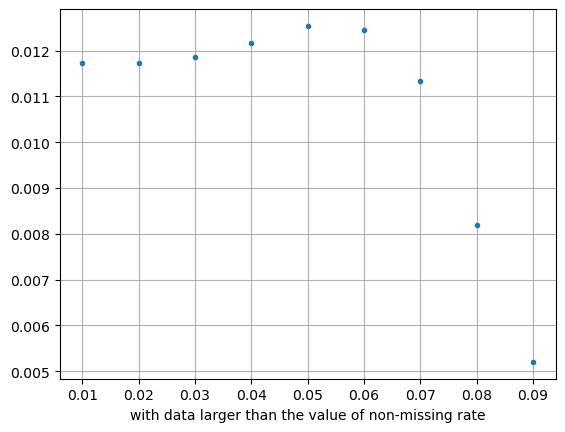

In [153]:
rmse_k100=[0.011718845062469205, 0.011733566569767748, 0.011857189689905543, 0.012175408280241933, 0.012537902574912135,
           0.012457821394958409, 0.011329832116100173, 0.008197304995008576, 0.0052040000840710594]
plt.plot(x_label, rmse_k100, '.')
plt.grid()


In [155]:
fcd_dt = pd.read_csv('fcd_dt_ht_with_stay_Seadt.csv', index_col=0)

In [156]:
fcd_dt

reids  time_5_new   taz  col_index  taz_index  sim_t  sim_ts  \
0        1001411_1           0  5002          0        169      1       0   
1        1001411_1           1  5002          0        169      0       0   
2        1001411_1           2  5002          0        169      0       0   
3        1001411_1           3  5002          0        169      0       0   
4        1001411_1           4  5002          0        169      0       0   
...            ...         ...   ...        ...        ...    ...     ...   
3127991   999423_1         283  5002          0        169      0       0   
3127992   999423_1         284  5002          0        169      0       0   
3127993   999423_1         285  5002          0        169      0       0   
3127994   999423_1         286  5002          0        169      0       0   
3127995   999423_1         287  5002          0        169      0       0   

         id_index  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
3127991     11708  
3127992     11708  
3127993     11708  
3127994     11708  
3127995     11708  

[3923914 rows x 8 columns]

In [8]:
loc_time = {}
index_ = 0
taz_ = np.unique(fcd_out['taz'])
time_ = np.unique((fcd_out['time']/300).astype(int))
for taz in taz_:
    for t in time_:
        loc_time[str(taz)+'_'+str(t)] = index_
        index_ += 1
        
loc_time = {}
index_ = 0
taz_ = np.unique(fcd_out['taz'])
time_ = np.unique((fcd_out['time']/300).astype(int))
for taz in taz_:
    for t in time_:
        loc_time[str(taz)+'_'+str(t)] = index_
        index_ += 1
        
newuser_ = {}
index_ = 0
for i in np.unique(fcd_out.id):
    newuser_[i] = index_
    index_ += 1
    
get_newid = lambda x: newuser_[x]
fcd_out['newid'] = fcd_out['id'].apply(get_newid)

In [523]:
#get the original data matrix
origin_dt = np.zeros((len(newuser_), len(loc_time)))
ids_ = fcd_out['id'].values
tl_id_ = fcd_out['tl_id'].values
for i in range(len(ids_)):
    origin_dt[newuser_[ids_[i]]][loc_time[tl_id_[i]]] = 1

In [524]:
#sim_dt_t = get_simdt(fcd_out, 'sim_obs', newuser_, loc_time)
#sim_dt_ts = get_simdt(fcd_out, 'sim_obs_ts', newuser_, loc_time)

def fit_dt(fcd_out, sim_col, newuser_, loc_time, k_val):
    sim_dt = get_simdt(fcd_out, sim_col, newuser_, loc_time)
    
    model = NMF(n_components=k_val, init='random', random_state=0)
    W = model.fit_transform(sim_dt)
    H = model.components_
    
    return(np.dot(W, H))

In [62]:
WH_ts = fit_dt(fcd_out, 'sim_obs_ts', newuser_, loc_time, 100)

In [96]:
pred_time_loc = get_pred_timedict(num_taz, time_interval)

In [10]:
#get time loc
#time_interval = 288
#num_taz = int(WH_ts.shape[1]/time_interval)

def get_timeloc(num_taz, time_interval, t):
    select_time_loc = []
    for i in range(num_taz):
        select_time_loc.append(time_interval*i+t)
    return(select_time_loc)

def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def get_maxvalnindex(WHpert):
    max_val = np.max(WHpert, axis=1)
    max_index = np.argmax(WHpert, axis=1)
    return(max_val, max_index)

def get_pred_dt(WH_pred, time_interval):
    num_taz = int(WH_pred.shape[1]/time_interval)
    print('num taz', num_taz)
    pred_time_dic = get_pred_timedict(num_taz, time_interval)
    for t in pred_time_dic:
        pred_val = WH_pred[:, pred_time_dic[t]]
        if t == 0:
            max_val, max_index = get_maxvalnindex(pred_val)
        else:
            max_val_cur, max_index_cur = get_maxvalnindex(pred_val)
            max_val = np.vstack((max_val, max_val_cur))
            max_index = np.vstack((max_index, max_index_cur))
    return(max_val.T, max_index.T)  

In [148]:
WH_max, WH_index = get_pred_dt(WH_ts, 288)

num taz 168


In [197]:
pd.DataFrame(WH_max).to_csv('WH_max_ts.csv')
pd.DataFrame(WH_index).to_csv('WH_index_ts.csv')

In [516]:
fcd_out.to_csv('fcd_out_cur.csv')

In [200]:
del(WH_ts)

In [ ]:
WH_ts =fit_dt(fcd_out, 'sim_obs', newuser_, loc_time, 100)

In [ ]:
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_t.csv')
pd.DataFrame(WH_index).to_csv('WH_index_t.csv')

del(WH_ts, WH_max, WH_index)

In [ ]:
WH_ts = fit_dt(fcd_out, 'sim_obs_ts', newuser_, loc_time, 1000)
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_ts_1000.csv')
pd.DataFrame(WH_index).to_csv('WH_index_ts_1000.csv')

del(WH_ts, WH_max, WH_index)

In [ ]:
WH_ts = fit_dt(fcd_out, 'sim_obs', newuser_, loc_time, 1000)
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_t_1000.csv')
pd.DataFrame(WH_index).to_csv('WH_index_t_1000.csv')

del(WH_ts, WH_max, WH_index)

In [9]:
#revised_dt
def check_fcd_obs(fcd_outdt):
    test = fcd_outdt.groupby(['id']).size().to_frame()
    test.reset_index(inplace=True)
    
    test.columns =['id', 'num_trip']
    #print(test.sort_values(by=['num_trip'], ascending=False))
    print(test.num_trip.describe())
    test = test.sort_values(by=['num_trip'])
    return(test)

def revise_fcd_dt(fcd_outpath):
    fcd_outdt = pd.read_csv(fcd_outpath, header=None)
    fcd_outdt.columns = ['id', 'TAZ', 'time']
    revise_dt = lambda x: x.split('-')[0] if '-' in x else x
    fcd_outdt['reids'] = fcd_outdt['id'].apply(revise_dt)
    fcd_outdt['time'] = fcd_outdt['time'].astype('int')
    fcd_outdt['hr'] = (fcd_outdt['time'].values/3600).astype(int)
    fcd_outdt['minus'] = (fcd_outdt['time'].values- fcd_outdt['hr'].values*3600)/60
    fcd_outdt['time_30'] = (fcd_outdt['time']/30).astype(int)
    fcd_outdt['time_5'] = (fcd_outdt['time']/300).astype(int)
    return(fcd_outdt)
    
def get_test_trace(fcd_outdt, id_info, zoneshp, plot_trajec=True):
    test_ = fcd_outdt[fcd_outdt['id'] == id_info]
    test_obs = test_.groupby(by=['TAZ']).sum()
    test_obs.reset_index(inplace=True)
    
    test_ = test_.sort_values(by=['id', 'time'])
    hr = test_['hr'].values
    minus = test_['minus'].values
    
    #check time span
    print('start time:', [hr[0], minus[0]])
    print('start time:', [hr[-1], minus[-1]])
    
    
    merged = zoneshp.set_index('TAZ').join(test_obs.set_index('TAZ'))
    merged.reset_index(inplace=True)
    merged['traj_index'] = 0
    merged['traj_index'][merged['TAZ'].isin(np.unique(test_.TAZ))] = 2
    merged['traj_index'][merged['time']==min(test_obs['time'])] = 1
    merged['traj_index'][merged['time']==max(test_obs['time'])] = 3
    
    if plot_trajec == True:
        cmap_style = plt.cm.get_cmap('Blues', 4)
        #selected_zone = np.unique(geoid_identify[:-4])
        fig, ax1 = plt.subplots(figsize=(16, 12))

        # set the range for the choropleth
        vmin, vmax = 0, 3
        variable = 'traj_index'
        merged.plot(column=variable, cmap=cmap_style, linewidth=0.8, \
                    ax=ax1, edgecolor='0.8')

        #cbar.set_yticklabels(['None', 'Starting zone', 'Passed', 'Ending zone'])
        ax3  = fig.add_axes([0.95,0.10,0.05,0.95])
        norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
        cb1  = mpl.colorbar.ColorbarBase(ax3,cmap=cmap_style,norm=norm,orientation='vertical')
        cb1.set_ticks([vmax/8,vmax*3./8,vmax*5./8,vmax*7./8])
        cb1.set_ticklabels(['None', 'Starting zone', 'Passed', 'Ending zone'])
        #saving our map as .png file.


    
def get_scaled_obs_mx(obs_mx):
    sum_val = np.sum(obs_mx, axis=0)
    loc_ = np.where(sum_val>0)

    vals_ = np.ones(len(sum_val))
    vals_[loc_] = sum_val[loc_]

    scaled_val = np.divide(obs_mx, np.tile(vals_, len(taz_index_dict)).reshape(168, 288))
    return(scaled_val)

def get_arr(start_index, end_index, checked_taz_index, repeat_num, obs_mx, add_obsval):
    #repeat_num = end_index-start_index
    taz_cur = np.argmax(obs_mx[:, checked_taz_index])
    
    taz_ = np.repeat(taz_cur, repeat_num)
    time_ = np.array(range(start_index, end_index))
    obs_ = np.repeat(add_obsval, repeat_num)
    
    return(np.vstack((taz_, time_, obs_)).T)
    

def get_add_mx(obs_mx):
    loc_ = np.where(obs_mx>0)
    pred_index = -1
    #we only care the non-zero time index instead of all the values
    end_index_pre = 0
    time_loc = np.unique(loc_[1])
    for time_index in time_loc:
        if time_index > 0:
            end_index_cur = time_index
            #print(end_index_pre, end_index_cur)
            if pred_index==-1:
                #print('processing init')
                start_index = 0
                if end_index_cur-start_index > 0:
                    repeat_num = end_index_cur-start_index
                    obs_mx_stay = get_arr(start_index, end_index_cur, 
                                          end_index_cur, repeat_num, 
                                          obs_mx, 4)
                    pred_index=1
            else:
                if end_index_cur-end_index_pre > 1:
                    #print('processing diff')
                    if pred_index == 1:
                        repeat_num = end_index_cur-(end_index_pre+1)
                        obs_mx_stay_cur = get_arr(end_index_pre+1, end_index_cur, 
                                                  end_index_cur, repeat_num,
                                                  obs_mx, 4)
                        obs_mx_stay = np.vstack((obs_mx_stay, obs_mx_stay_cur))       
                    else:
                        repeat_num = end_index_cur-(end_index_pre+1)
                        obs_mx_stay = get_arr(end_index_pre+1, end_index_cur, 
                                              end_index_cur, repeat_num,
                                              obs_mx, 4)

        end_index_pre = time_index

    if end_index_pre < 287:
        taz_cur = np.argmax(obs_mx[:, end_index_pre])
        start_index = end_index_pre+1
        end_index = 287
        repeat_num = end_index+1-start_index
        obs_mx_stay_cur = get_arr(start_index, end_index+1, 
                                 end_index_pre, repeat_num,
                                 obs_mx, 4)
        if pred_index == -1:
            obs_mx_stay = obs_mx_stay_cur
            pred_index = 1
        else:
            obs_mx_stay = np.vstack((obs_mx_stay, obs_mx_stay_cur))        
    return(obs_mx_stay)

#add value to the final matrix
def refill_mx(add_mx, obs_mx):
    for taz_, time_, obs_ in add_mx:
        obs_mx[taz_, time_] = obs_
    return(obs_mx.flatten())

def revise_userid(fcd_out, idcol):
    newuser_ = {}
    index_ = 0
    for i in np.unique(fcd_out[idcol].values):
        newuser_[i] = index_
        index_ += 1
    
    get_newid = lambda x: newuser_[x]
    fcd_out['newid'] = fcd_out[idcol].apply(get_newid)
    return(fcd_out)

def get_dataobs(csv_path, fcd_out_dt):
    data_obs = pd.read_csv(csv_path, header=0)
    get_hr = lambda x: x.split(':')[0]
    get_min = lambda x: x.split(':')[1]
    
    hr_ = np.unique(data_obs['time'].astype(str).apply(get_hr).astype(int))
    min_ = np.unique(data_obs['time'].astype(str).apply(get_min).astype(int))
    #taz_ = np.unique(data_obs['taz'])

    data_obs['hr'] = data_obs['time'].astype(str).apply(get_hr).astype(int)
    data_obs['min'] = data_obs['time'].astype(str).apply(get_min).astype(int)
    data_obs = data_obs[data_obs['taz'].isin(np.unique(fcd_out_dt.TAZ))]
    data_obs['taz_index'] = data_obs['taz'].apply(get_taz_index)
    data_obs['time_5'] = (data_obs['hr']*12+data_obs['min']/5).astype(int)
    return(data_obs)

In [25]:
#read app-based data
csv_path = '../data-1670309862526.csv'
#'fcd_output_10per_ht_30sec.csv'
fcd_dt_path = 'fcd_output_10per_all_30sec.csv'
#savepath = 'origin_dt.csv'

fcd_dt = revise_fcd_dt(fcd_dt_path)
#delete time period >than 288 (> than one day)
fcd_dt = fcd_dt[fcd_dt['time_5']<288]
fcd_dt = fcd_dt.sort_values(by=['reids', 'time'])

fcd_dt = revise_userid(fcd_dt, 'reids')

index_ = 0
taz_index_dict = {}
for i in np.unique(fcd_dt.TAZ):
    taz_index_dict[i] = index_
    index_+= 1
    
index_taz_dict = {}
for i in taz_index_dict:
    index_taz_dict[taz_index_dict[i]] = i
    
get_taz_index = lambda x: taz_index_dict[x]
fcd_dt['taz_index'] = fcd_dt['TAZ'].apply(get_taz_index)

In [27]:
len(np.unique(fcd_dt['reids']))

16701

In [30]:
ids = np.unique(fcd_dt['reids'])

In [ ]:

index = 0
#ids checked, now is 58436 (code: list(ids).index(id_index))
for id_index in ids:
    #print(id_index)
    obs_mx_id = get_obs_mx(fcd_out_30, id_index)
    add_mx = get_add_mx(obs_mx_id)
    if index == 0:
        revise_input = refill_mx(add_mx, obs_mx_id)
        index = 1
    else:
        revise_input_cur = refill_mx(add_mx, obs_mx_id)
        revise_input = np.vstack((revise_input, revise_input_cur))

In [91]:
fcd_dt.columns

Index(['id', 'TAZ', 'time', 'reids', 'hr', 'minus', 'time_30', 'time_5',
       'newid', 'taz_index'],
      dtype='object')

In [97]:
np.unique(fcd_dt['time_30'])

array([   0,    1,    2, ..., 2877, 2878, 2879])

In [96]:
fcd_obs = fcd_dt.groupby(by=['reids', 'time_30', 'taz_index']).size().to_frame()
fcd_obs.reset_index(inplace=True)

In [95]:
fcd_obs[fcd_obs['reids'] == '1002374_1']

reids  time_5  taz_index  0
0   1002374_1      36         83  2
1   1002374_1      36         93  2
2   1002374_1      36         94  1
3   1002374_1      36        109  1
4   1002374_1      36        154  1
5   1002374_1      36        164  3
6   1002374_1      37         54  1
7   1002374_1      37         72  1
8   1002374_1      56         53  2
9   1002374_1      56         54  1
10  1002374_1      56         55  1
11  1002374_1      57         62  1
12  1002374_1      57         73  1
13  1002374_1      57         74  1
14  1002374_1      57         75  1
15  1002374_1      57         77  1
16  1002374_1      57        117  1

In [47]:
reids_val = fcd_obs['reids'].values
time_5_val = fcd_obs['time_5'].values
taz_index_val = fcd_obs['taz_index'].values
obs_val = fcd_obs[0].values
num_obs_val = fcd_obs.groupby(['reids']).size().values

In [60]:
ids = np.unique(reids_val)

array(['1002374_1', '1003525_3', '1004248_2', ...,
       'Link_light_rail_52084614', 'Link_light_rail_52084615',
       'Link_light_rail_52084616'], dtype=object)

In [86]:
start_index = 0
end_index = 0

for i in range(len(ids)):
    end_index = end_index + num_obs_val[i]
    obs_mx = np.zeros((len(taz_index_dict),288))
    
    taz_cur = taz_index_val[start_index:end_index]
    time_cur = time_5_val[start_index:end_index]
    obs_cur = obs_val[start_index:end_index]
    mean_cur = int(round(np.mean(obs_cur), 0))
    print(taz_cur, time_cur, obs_cur, mean_cur)
    start_index = start_index+num_obs_val[i]
    break

[ 83  93  94 109 154 164  54  72  53  54  55  62  73  74  75  77 117] [36 36 36 36 36 36 37 37 56 56 56 57 57 57 57 57 57] [2 2 1 1 1 3 1 1 2 1 1 1 1 1 1 1 1] 1


In [79]:
time_5_val[0:17]

array([36, 36, 36, 36, 36, 36, 37, 37, 56, 56, 56, 57, 57, 57, 57, 57, 57],
      dtype=int64)

In [81]:
time_5_val
taz_index_val

array([ 83,  93,  94, ...,  82, 123, 125], dtype=int64)

In [56]:
def get_add_mx(obs_mx):
    loc_ = np.where(obs_mx>0)
    pred_index = -1
    #we only care the non-zero time index instead of all the values
    end_index_pre = 0
    time_loc = np.unique(loc_[1])
    for time_index in time_loc:
        if time_index > 0:
            end_index_cur = time_index
            #print(end_index_pre, end_index_cur)
            if pred_index==-1:
                #print('processing init')
                start_index = 0
                if end_index_cur-start_index > 0:
                    repeat_num = end_index_cur-start_index
                    obs_mx_stay = get_arr(start_index, end_index_cur, 
                                          end_index_cur, repeat_num, 
                                          obs_mx, 4)
                    pred_index=1
            else:
                if end_index_cur-end_index_pre > 1:
                    #print('processing diff')
                    if pred_index == 1:
                        repeat_num = end_index_cur-(end_index_pre+1)
                        obs_mx_stay_cur = get_arr(end_index_pre+1, end_index_cur, 
                                                  end_index_cur, repeat_num,
                                                  obs_mx, 4)
                        obs_mx_stay = np.vstack((obs_mx_stay, obs_mx_stay_cur))       
                    else:
                        repeat_num = end_index_cur-(end_index_pre+1)
                        obs_mx_stay = get_arr(end_index_pre+1, end_index_cur, 
                                              end_index_cur, repeat_num,
                                              obs_mx, 4)

        end_index_pre = time_index

    if end_index_pre < 287:
        taz_cur = np.argmax(obs_mx[:, end_index_pre])
        start_index = end_index_pre+1
        end_index = 287
        repeat_num = end_index+1-start_index
        obs_mx_stay_cur = get_arr(start_index, end_index+1, 
                                 end_index_pre, repeat_num,
                                 obs_mx, 4)
        if pred_index == -1:
            obs_mx_stay = obs_mx_stay_cur
            pred_index = 1
        else:
            obs_mx_stay = np.vstack((obs_mx_stay, obs_mx_stay_cur))        
    return(obs_mx_stay)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
obs_mx_id = get_obs_mx(fcd_dt, ids[0], 'reids')
add_mx = get_add_mx(obs_mx_id)

revise_input = refill_mx(add_mx, obs_mx_id)

In [39]:
obs_mx_id.shape

(168, 288)

In [37]:
add_mx.shape

(284, 3)

In [42]:
np.count_nonzero(revise_input)

301

In [34]:
len(np.unique(revise_input))

5

In [ ]:
revise_input.shape

In [ ]:
revised_input.to_csv('C:\\Users\\Yiran\\Desktop\\YiranZhang\\sumo_simulation\\revised_input.csv')

In [ ]:
#get sampled_loc
obs_mx_stay = pd.DataFrame(np.vstack((np.where(revise_input > 0)[0], np.where(revise_input > 0)[1], 
                                 revise_input[np.where(revise_input>0)])).T)
obs_mx_stay.columns = ['newid', 'tsid', 'obs']

In [ ]:
obs_mx_stay['time_5'] = obs_mx_stay['tsid']%288
obs_mx_stay['taz_index'] = obs_mx_stay['tsid']//288

In [ ]:
def revise_fcd_dt(fcd_outpath):
    fcd_outdt = pd.read_csv(fcd_outpath, header=None)
    fcd_outdt.columns = ['id', 'TAZ', 'time']
    fcd_outdt['time'] = fcd_outdt['time'].astype('int')
    fcd_outdt['hr'] = (fcd_outdt['time'].values/3600).astype(int)
    fcd_outdt['minus'] = (fcd_outdt['time'].values- fcd_outdt['hr'].values*3600)/60
    fcd_outdt['time_30'] = (fcd_outdt['time']/30).astype(int)
    fcd_outdt['time_5'] = (fcd_outdt['time']/300).astype(int)
    return(fcd_outdt)

def revise_userid(fcd_out):
    newuser_ = {}
    index_ = 0
    for i in np.unique(fcd_out.id):
        newuser_[i] = index_
        index_ += 1
    
    get_newid = lambda x: newuser_[x]
    fcd_out['newid'] = fcd_out['id'].apply(get_newid)
    return(fcd_out)

def get_dataobs(csv_path, fcd_out_dt):    
    get_hr = lambda x: x.split(':')[0]
    get_min = lambda x: x.split(':')[1]
    
    data_obs = pd.read_csv(csv_path, header=0)
    hr_ = np.unique(data_obs['time'].astype(str).apply(get_hr).astype(int))
    min_ = np.unique(data_obs['time'].astype(str).apply(get_min).astype(int))
    #taz_ = np.unique(data_obs['taz'])

    data_obs['hr'] = data_obs['time'].astype(str).apply(get_hr).astype(int)
    data_obs['min'] = data_obs['time'].astype(str).apply(get_min).astype(int)
    data_obs = data_obs[data_obs['taz'].isin(np.unique(fcd_out_30.TAZ))]
    data_obs['taz_index'] = data_obs['taz'].apply(get_taz_index)
    data_obs['time_5'] = (data_obs['hr']*12+data_obs['min']/5).astype(int)
    return(data_obs)

In [ ]:
data_obs = get_dataobs(csv_path, fcd_out_30)
time_per = data_obs.groupby(by = ['time_5']).size().values
time_per = time_per/np.max(time_per)
avg_time_per = np.mean(time_per)

#get per based on time and spatial info
st_obs = data_obs.groupby(by=['taz_index', 'time_5']).size().to_frame()
st_obs.reset_index(inplace=True)
st_obs.columns = ['taz_index', 'time_5', 'obs']

taz_val = st_obs['taz_index'].values
time_val = st_obs['time_5'].values
obs = st_obs['obs'].values

st_per = np.zeros((len(np.unique(taz_val)), len(np.unique(time_val))))

re_revise_taz = {}
index_ = 0
for i in np.unique(taz_val):
    re_revise_taz[i] = index_
    index_ += 1
    
get_re_index = lambda x: re_revise_taz[x]
st_obs['taz_re_index'] = st_obs['taz_index'].apply(get_re_index)
taz_val = st_obs['taz_re_index'].values

st_per[taz_val, time_val] = obs

st_per = np.divide(st_per, np.tile(np.max(st_per, axis=1).reshape(len(np.unique(taz_val)),1), 288))
st_per_avg = np.mean(st_per, axis=0)

In [ ]:
get_re_index = lambda x: re_revise_taz[x] if x in re_revise_taz else -1
obs_mx_stay['taz_re_index'] = obs_mx_stay['taz_index'].apply(get_re_index)

In [268]:
time_5

array([ 0.,  1.,  2., ..., 72., 73., 72.])

In [ ]:
#conduct_sim
time_5 = obs_mx_stay['time_5'].values
obs = obs_mx_stay['obs'].values
taz_ = obs_mx_stay['taz_re_index'].values

sim_obs_t = []
sim_obs_ts = []
for i in range(len(time_5)):
    #print(obs[i])
    sim_obs_t.append(np.sum(np.random.binomial(1, time_per[int(time_5[i])], size=int(obs[i]))))
    if taz_[i] != -1:
        sim_obs_ts.append(np.sum(np.random.binomial(1, st_per[int(taz_[i]),int(time_5[i])], size=int(obs[i]))))
    else:
        sim_obs_ts.append(np.sum(np.random.binomial(1, st_per_avg[int(time_5[i])], size=int(obs[i]))))

In [ ]:
sim_obs_t = np.array(sim_obs_t)
sim_obs_ts = np.array(sim_obs_ts)

In [ ]:
#get time loc
time_interval = 288
num_taz = int(revise_input.shape[1]/time_interval)

def get_timeloc(num_taz, time_interval, t):
    select_time_loc = []
    for i in range(num_taz):
        select_time_loc.append(time_interval*i+t)
    return(select_time_loc)

def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def get_maxvalnindex(WHpert):
    max_val = np.max(WHpert, axis=1)
    max_index = np.argmax(WHpert, axis=1)
    return(max_val, max_index)

def get_pred_dt(WH_pred, time_interval):
    num_taz = int(WH_pred.shape[1]/time_interval)
    print('num taz', num_taz)
    pred_time_dic = get_pred_timedict(num_taz, time_interval)
    for t in pred_time_dic:
        pred_val = WH_pred[:, pred_time_dic[t]]
        if t == 0:
            max_val, max_index = get_maxvalnindex(pred_val)
        else:
            max_val_cur, max_index_cur = get_maxvalnindex(pred_val)
            max_val = np.vstack((max_val, max_val_cur))
            max_index = np.vstack((max_index, max_index_cur))
    return(max_val.T, max_index.T)  

In [ ]:
obs_mx_stay.head(3)

In [ ]:
obs_mx_stay['newid'] = obs_mx_stay['newid'].astype(int)
obs_mx_stay['tsid'] = obs_mx_stay['tsid'].astype(int)

In [ ]:
sim_dt = np.zeros(revise_input.shape)
sim_dt[obs_mx_stay['newid'].values, obs_mx_stay['tsid'].values] = sim_obs_t

In [ ]:
obs_mx_stay.to_csv('C:\\Users\\Yiran\\Desktop\\YiranZhang\\obs_mx_stay.csv')

In [ ]:
def fit_dt_nmf(sim_dt, k_val):    
    model = NMF(n_components=k_val, init='random', random_state=0)
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

In [ ]:
#separate the time (suppose we only check the similar pattern during similar time)
#source: https://ops.fhwa.dot.gov/perf_measurement/ucr/documentation.htm#:~:text=Averages%20are%20weighted%20across%20road,to%207%20pm)%20on%20weekdays.
#mor peak 6-9 AM
#noon 9-16
#eve peak 4-7 (16-19)
#other 0-6 AM, 19-24

In [ ]:
#6-9
#287//12
#287%12
#get time period
time_dict = {'mor': list(range(6, 9)),
            'eve':list(range(16, 19)),
            'noon': list(range(9, 16))}

def get_time_period(time_dict, time_interval, time_step, num_taz):
    time_loc = {}
    time_loc = {'mor':[], 'eve':[], 'noon':[], 'other':[]}
    for i in range(time_interval):
        #print(i)
        hr = i//time_step
        #print(hr)
        if hr in time_dict['mor']:
            time_loc['mor'].extend(get_timeloc(num_taz, time_interval, i))
        elif hr in time_dict['eve']:
            time_loc['eve'].extend(get_timeloc(num_taz, time_interval, i))
        elif hr in time_dict['noon']:
            time_loc['noon'].extend(get_timeloc(num_taz, time_interval, i))
        else:
            time_loc['other'].extend(get_timeloc(num_taz, time_interval, i))
            
        #tide the time loc order
        for i in time_loc:
            time_loc[i] = sorted(time_loc[i])
    return(time_loc)
    

In [ ]:
time_period_loc = get_time_period(time_dict, 288, 12, 168)
 
for i in time_period_loc:
    print(len(time_period_loc[i]))
    

    

In [ ]:
def get_predbytime(sim_dt, k_val, time_period_dict):
    #separate the data
    for time_period in time_period_dict:
        sim_dt_t = sim_dt[:, time_period_dict[time_period]]
        print(sim_dt_t.shape)
        WH_ts = fit_dt_stay(sim_dt_t, k_val)
        WH_max, WH_index = get_pred_dt(WH_ts, 288)
        pd.DataFrame(WH_max).to_csv('WH_max_t_stay_'+str(k_val)+'_'+time_period+'.csv')
        pd.DataFrame(WH_index).to_csv('WH_index_t_stay'+str(k_val)+'_'+time_period+'.csv')
        

In [ ]:
get_predbytime(sim_dt, 100, time_period_loc)

In [ ]:
get_predbytime(sim_dt)

In [363]:
for time_period in time_period_loc:
    print(time_period)

mor
eve
noon
other


In [ ]:
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_t_stay_100.csv')
pd.DataFrame(WH_index).to_csv('WH_index_t_stay_100.csv')

del(WH_ts, WH_max, WH_index, sim_dt)

In [ ]:
sim_dt = np.zeros(revise_input.shape)
sim_dt[obs_mx_stay['newid'].values, obs_mx_stay['tsid'].values] = sim_obs_ts

In [ ]:
WH_ts = fit_dt_stay(obs_mx_stay, revise_input, sim_obs_ts, 100)
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_ts_stay_100.csv')
pd.DataFrame(WH_index).to_csv('WH_index_ts_stay_100.csv')

del(WH_ts, WH_max, WH_index, sim_dt)

In [80]:
#np.max(WH_ts[:, pred_time_loc[0]], axis=1).shape

[array([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]),
 array([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])]

(60711, 288)

In [22]:
#example of NMF
#X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

#starting time 10:07 pm 
model = NMF(n_components=100, init='random', random_state=0)
W = model.fit_transform(sim_dt_ts)
H = model.components_

WH = np.dot(W, H)
#therefore we have
#origin_dt (ground truth)
#sim_dt (time variation based sampling)
#WH (nmf pred based on sim_dt)

#check rmse
#mean_squared_error(origin_dt, sim_dt, squared=False)
#0.003269806981300681
#mean_squared_error(origin_dt, WH, squared=False)
#0.005064870617568365
#mean_squared_error(sim_dt, WH, squared=False)
#0.0028294665247159886

#save the predicted W and H
#pd.DataFrame(W).to_csv('W_time.csv')
#pd.DataFrame(H).to_csv('H_time.csv')

#convert WH

In [9]:
#another thoughts for spatial variation 
#generate error/biased spatial location
#conduct spatial variation
Seattle_taz = gpd.read_file('test_taz_Seattle_1.shp')
#processing the None value
Seattle_taz['nb_t'].loc[[list(Seattle_taz['nb_t'].values == None).index(True)]] = '1'
Seattle_taz['nb_agg'] = Seattle_taz['nb']+','+Seattle_taz['nb_touch']+','+Seattle_taz['nb_inter']+','+Seattle_taz['nb_t']

#functions

def get_nbtaz(agg_val):
    nb_taz = []
    for taz in agg_val.split(','):
        nb_taz.append(int(taz))
    return(np.unique(nb_taz))

def get_taz_nb_dict(taz_lst, nb_agg_lst, selected_taz):
    taz_nb_dict = {}
    index_ = 0
    for taz in taz_lst:
        if taz in selected_taz:
           # print(taz)
           # print(index_)
            taz_nb_dict[taz] = get_nbtaz(nb_agg_lst[index_])
        index_ += 1
    return(taz_nb_dict)

def process_taz(nb_arr, taz, selected_taz):
    nb_cur = []
    for i in nb_arr:
        if i in selected_taz:
            nb_cur.append(i)
            
    #remove the origin taz in the taz lst
    nb_cur.remove(taz)
    return(nb_cur)

Seattle_taz_nb = get_taz_nb_dict(list(Seattle_taz['TAZ'].values),
                                list(Seattle_taz['nb_agg'].values),
                                taz_)

#process the neighborhood taz, delete all inavailable tazs (not within
#downtown Seattle)
for taz in Seattle_taz_nb:
    Seattle_taz_nb[taz] = process_taz(Seattle_taz_nb[taz], taz, taz_)
    
del(Seattle_taz)


#spatial variation simulaiton
#given a probability follows bernoulli distribution
#if true, the point stays in the original taz, otherwise randomly assign
#the neighborhood taz to it
taz = 426
per = .8
index_ = np.random.binomial(1, per, 1)[0]
if index_==0:
    print(random.choice(Seattle_taz_nb[taz]))
else:
    print(taz)

C:\Users\Yiran\AppData\Local\Temp\ipykernel_17936\4075502661.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Seattle_taz['nb_t'].loc[[list(Seattle_taz['nb_t'].values == None).index(True)]] = '1'


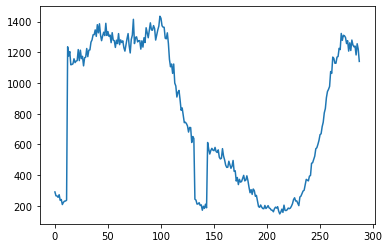

In [6]:
#previous figure check
#app-based data plot (based on time variation)

C:\Users\Yiran\AppData\Local\Temp\ipykernel_17936\2337170958.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(taz)


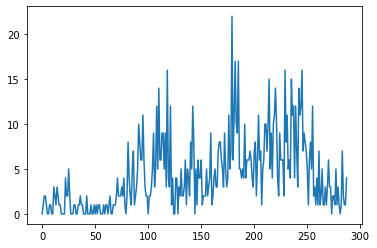

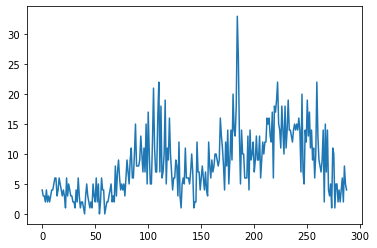

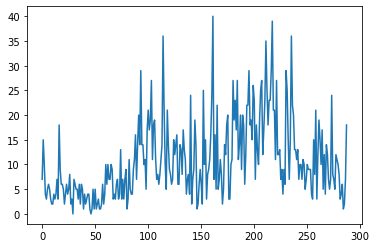

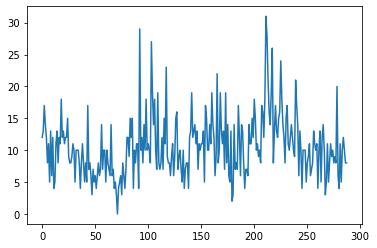

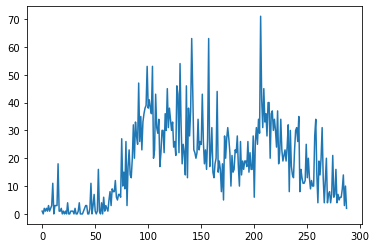

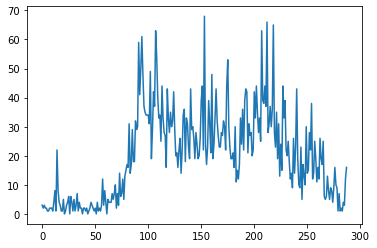

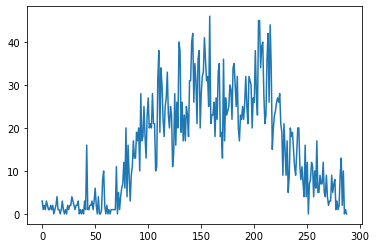

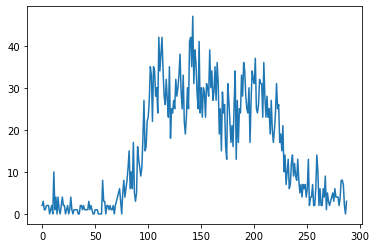

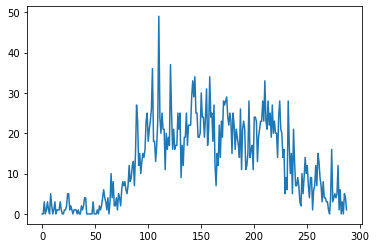

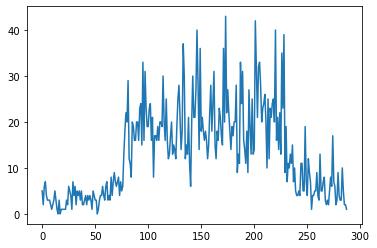

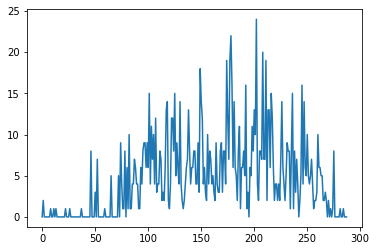

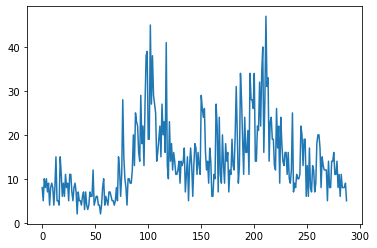

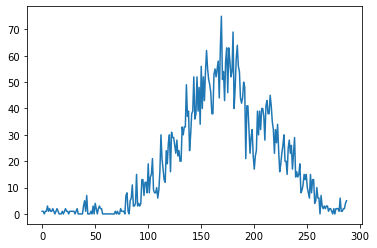

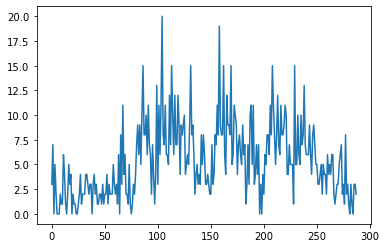

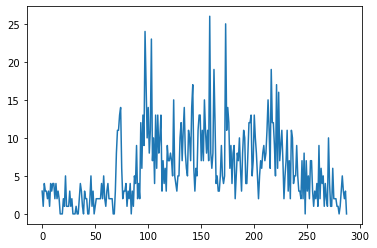

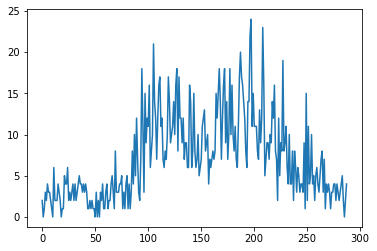

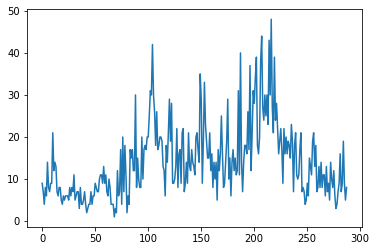

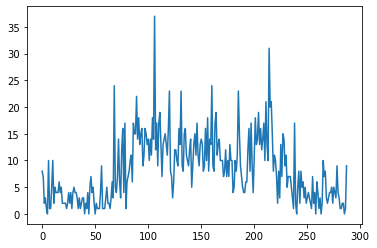

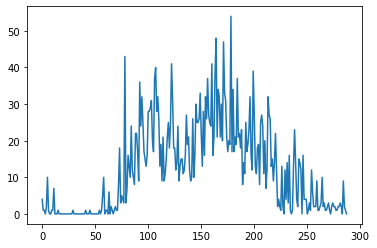

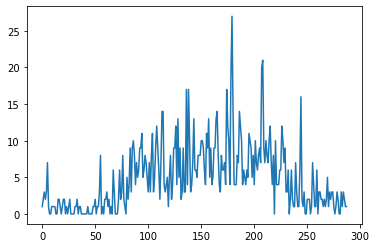

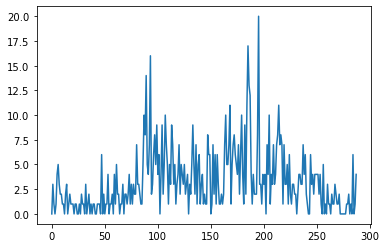

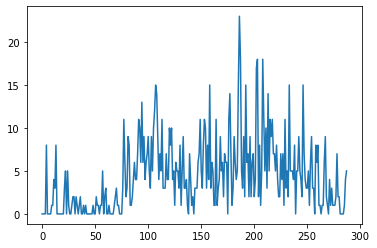

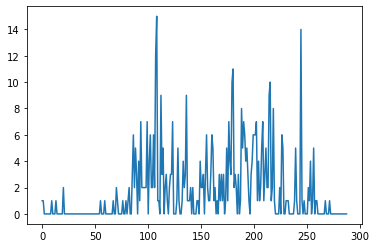

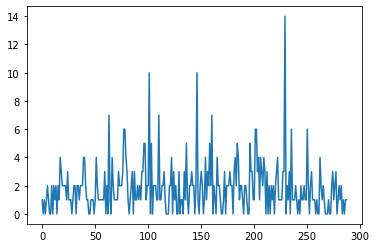

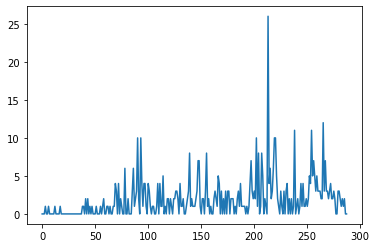

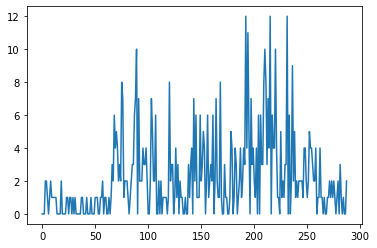

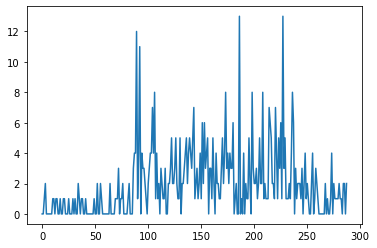

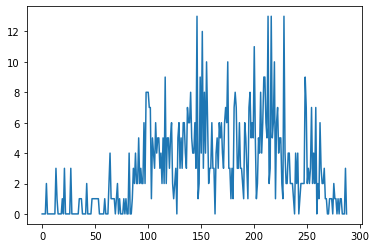

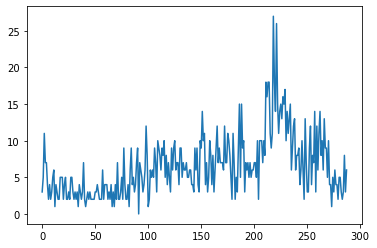

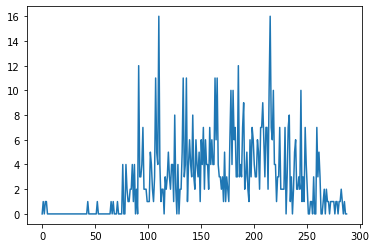

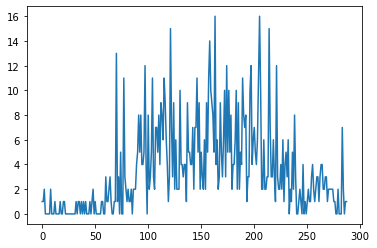

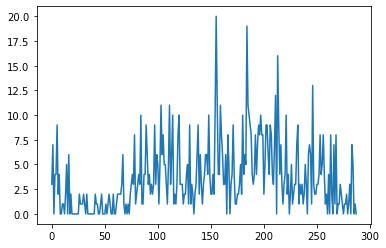

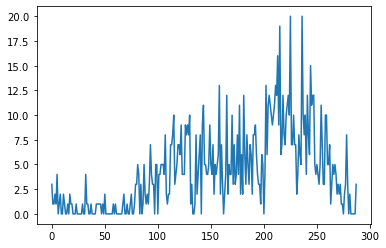

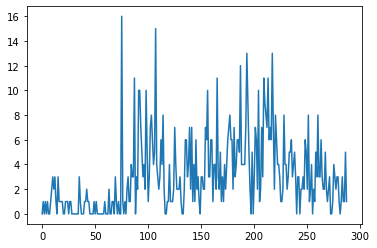

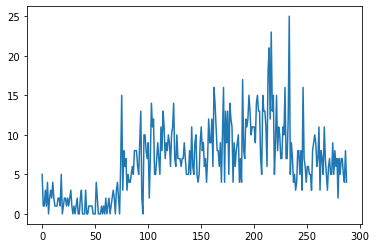

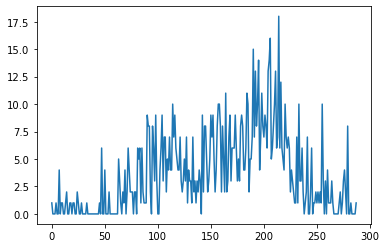

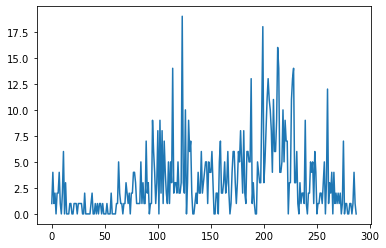

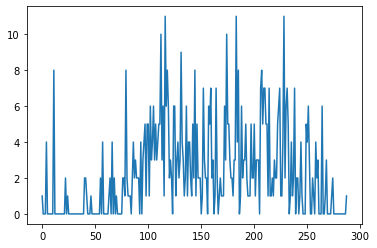

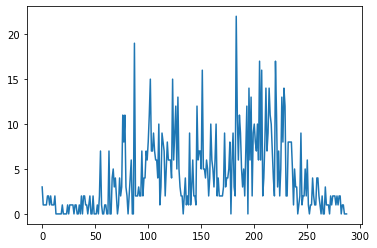

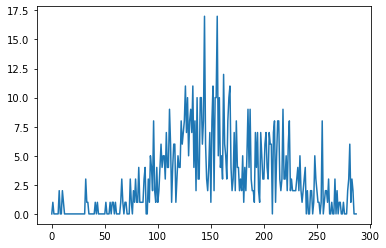

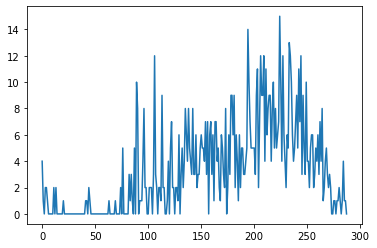

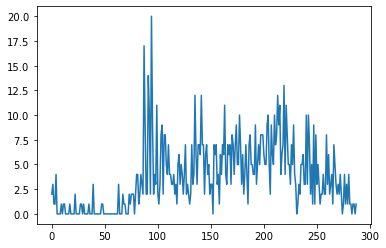

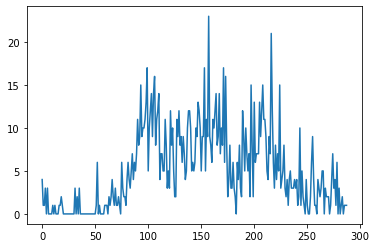

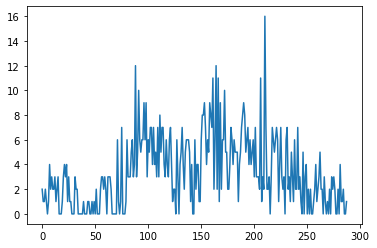

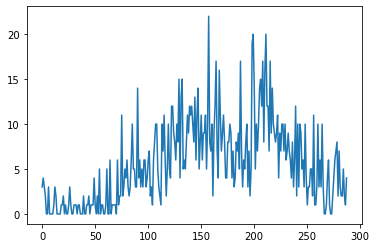

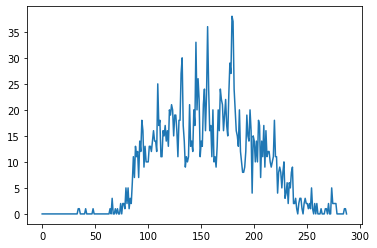

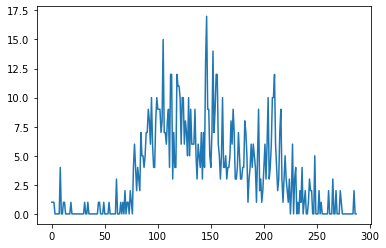

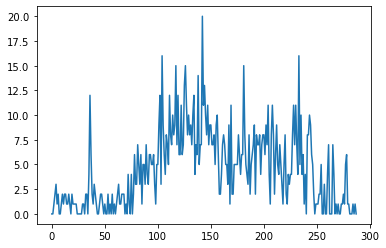

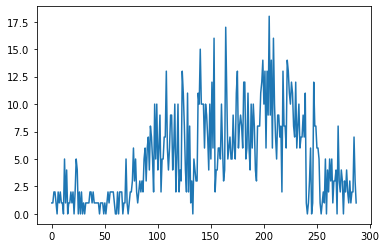

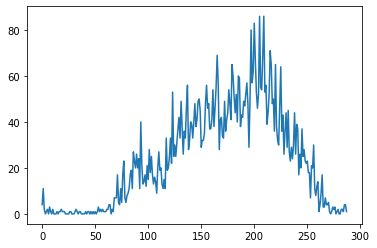

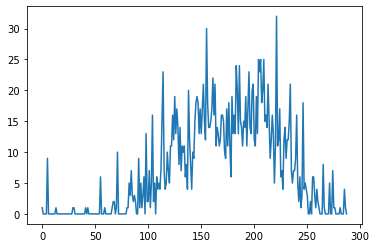

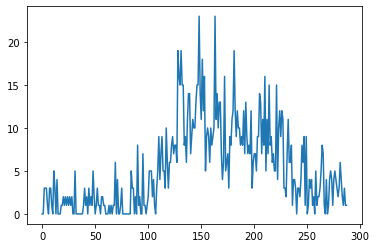

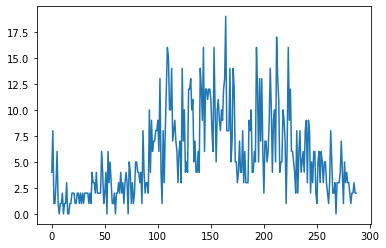

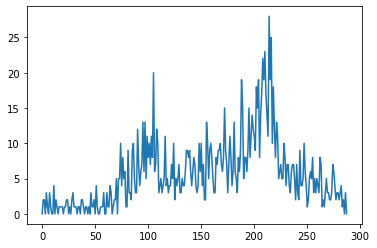

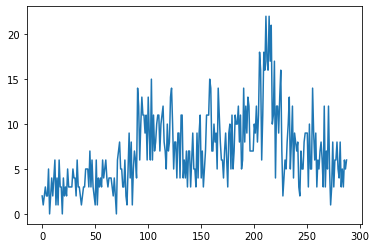

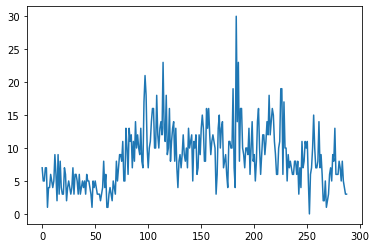

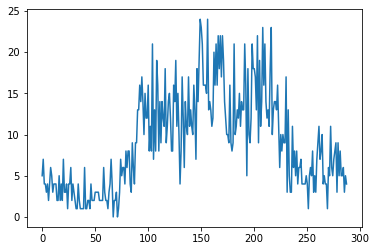

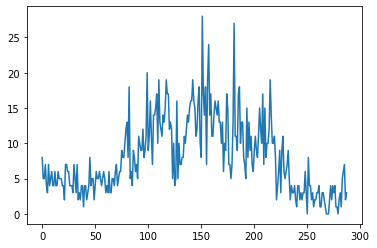

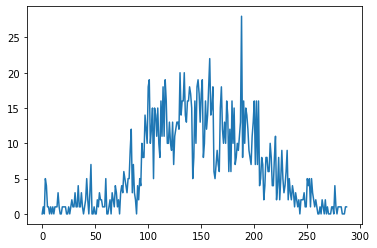

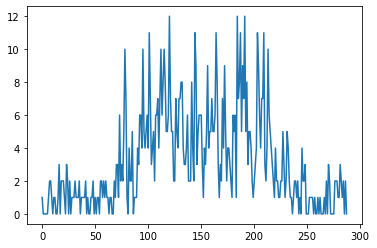

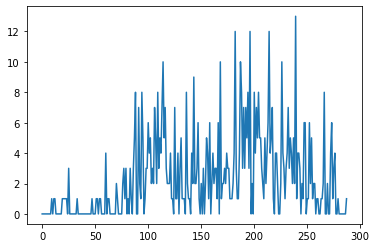

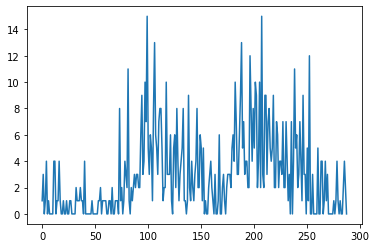

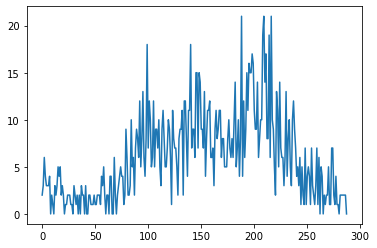

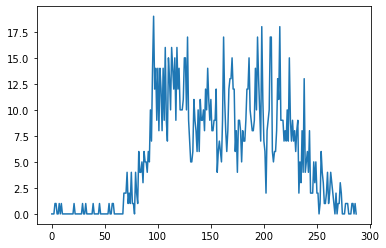

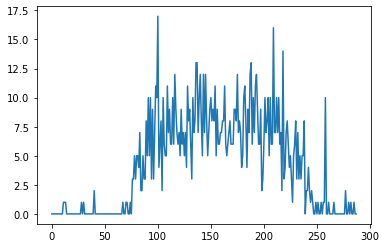

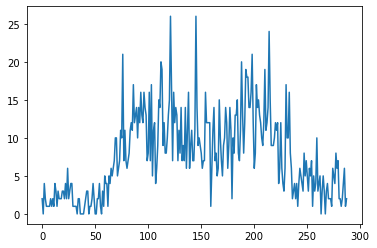

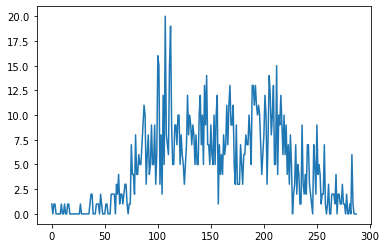

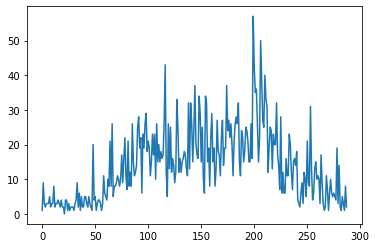

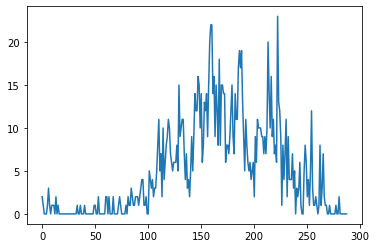

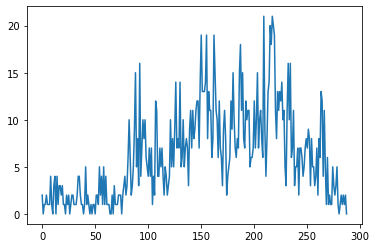

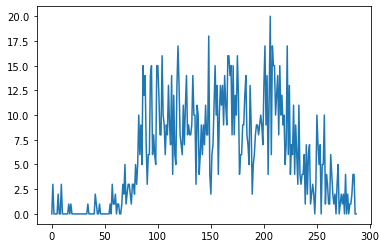

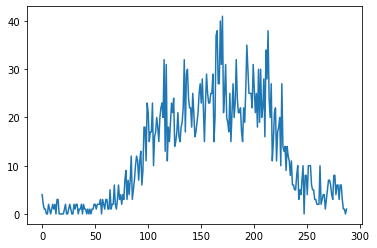

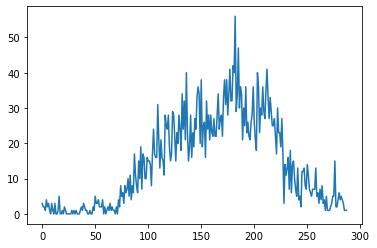

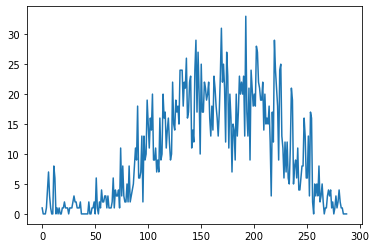

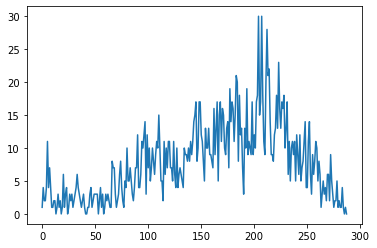

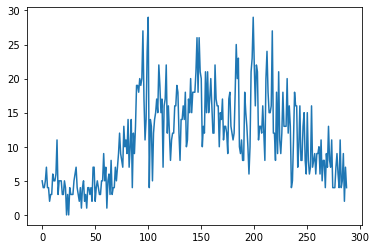

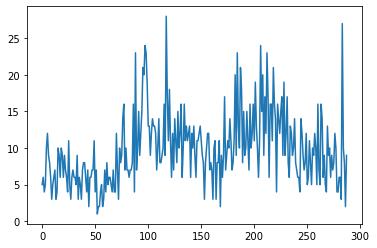

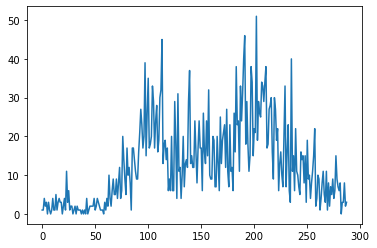

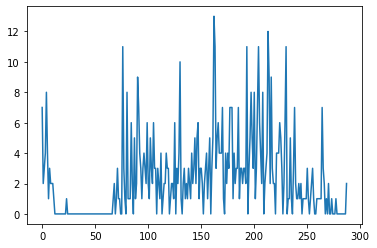

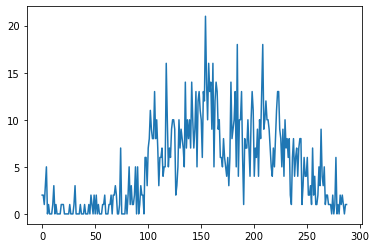

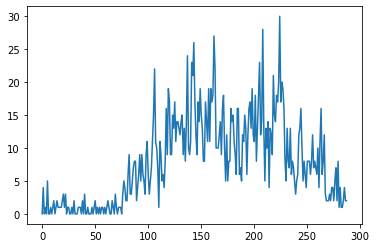

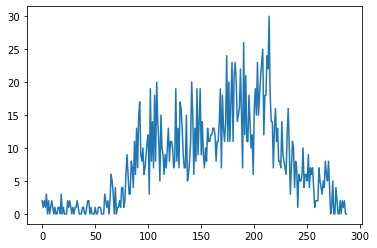

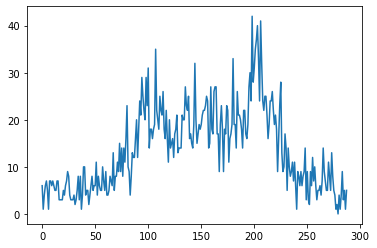

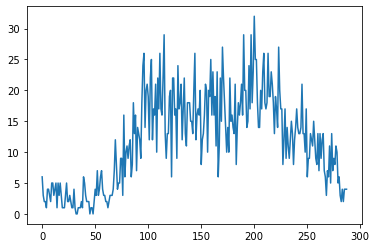

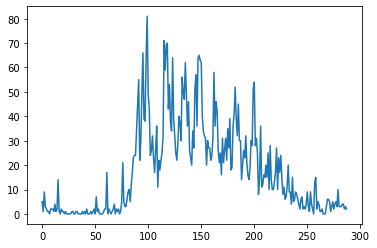

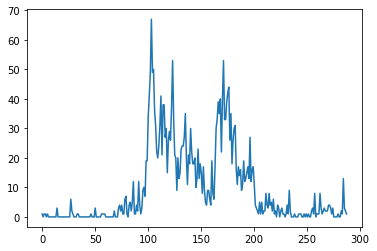

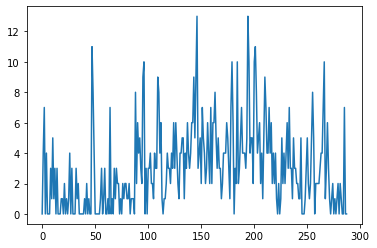

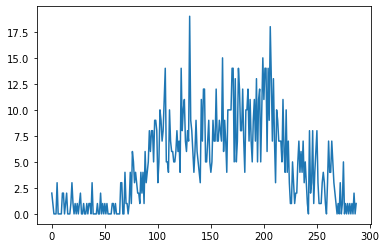

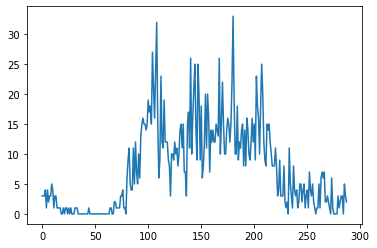

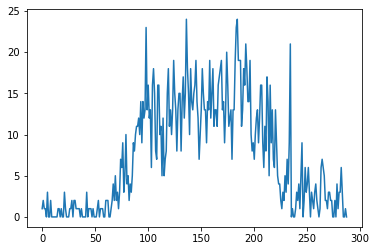

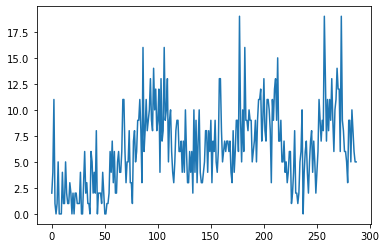

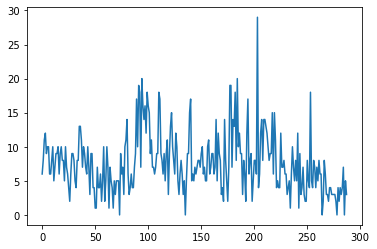

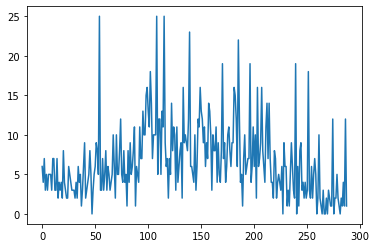

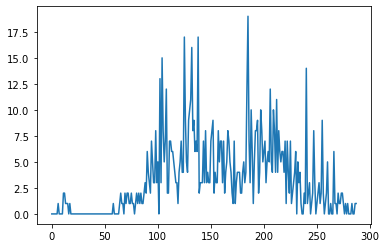

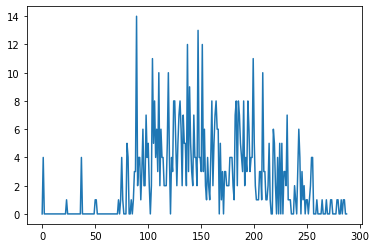

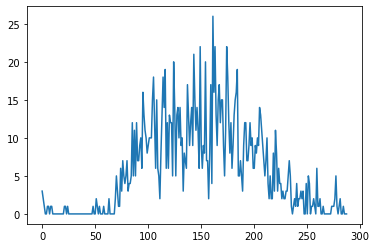

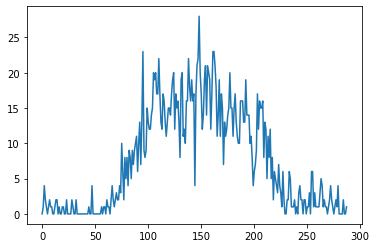

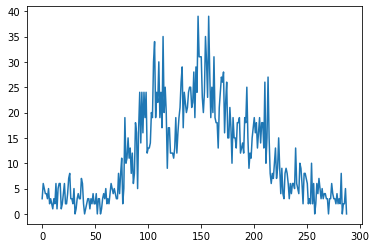

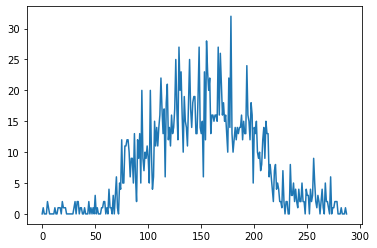

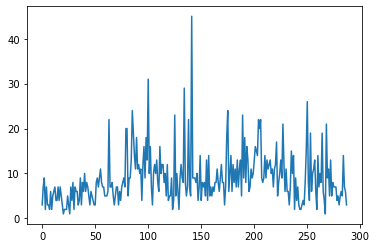

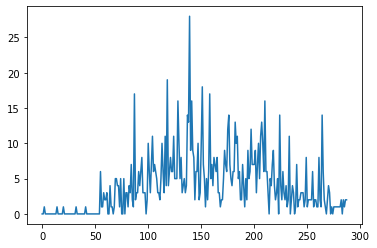

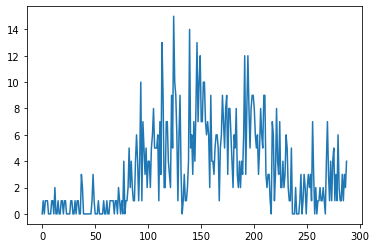

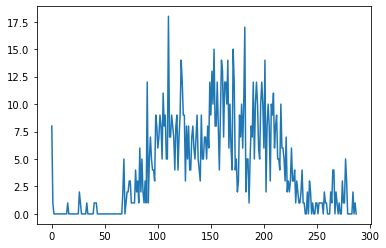

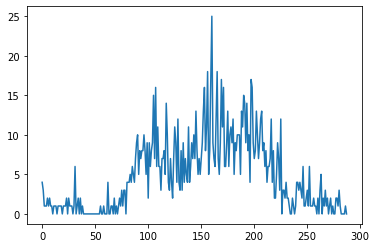

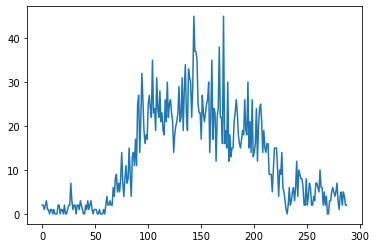

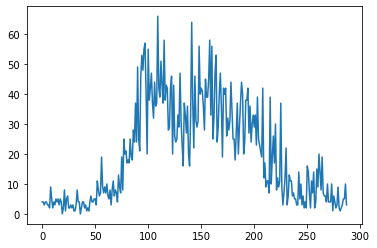

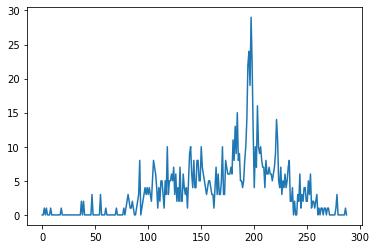

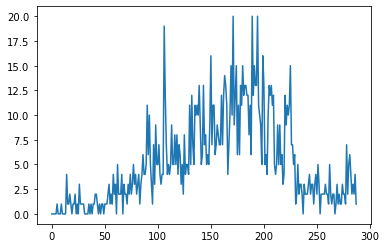

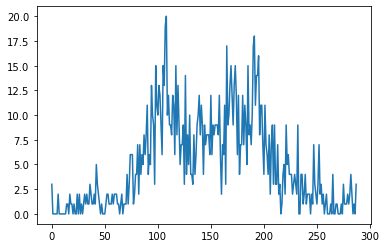

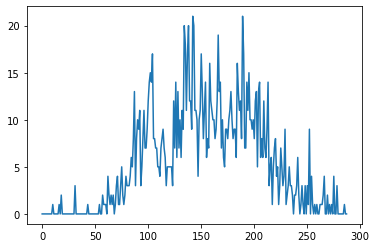

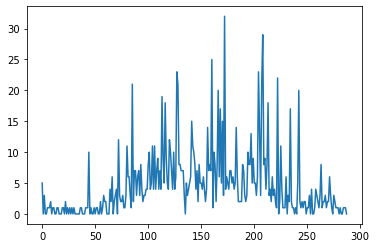

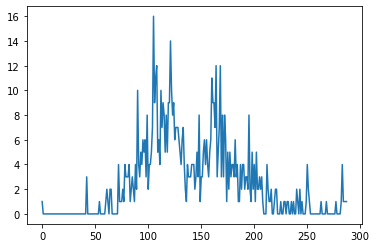

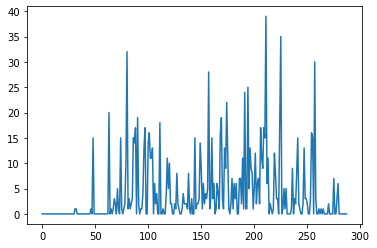

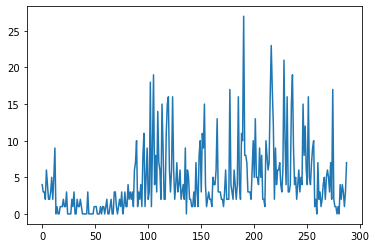

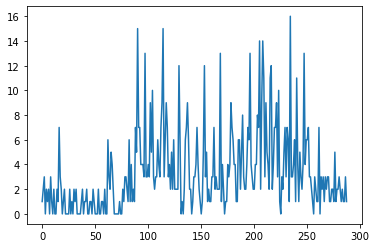

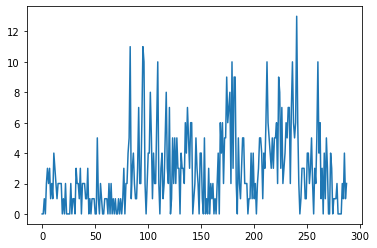

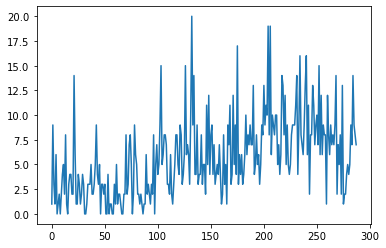

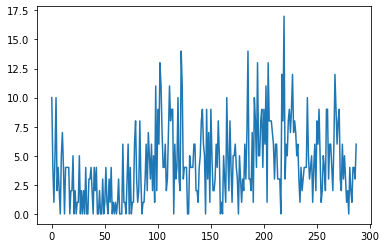

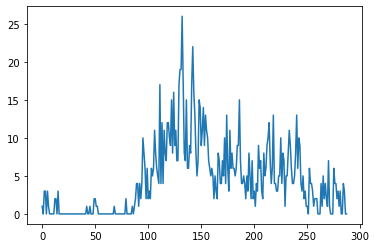

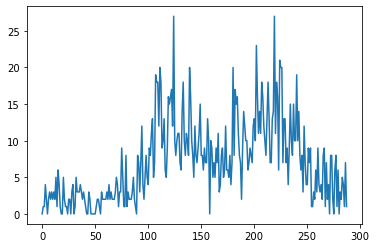

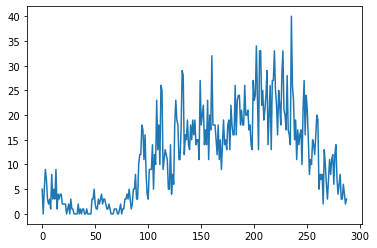

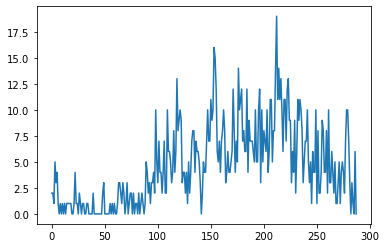

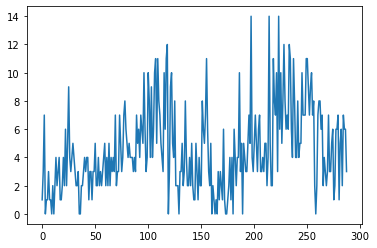

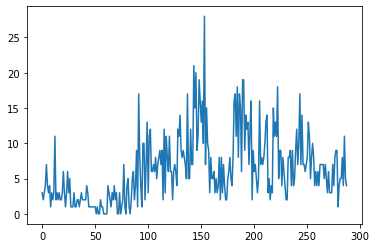

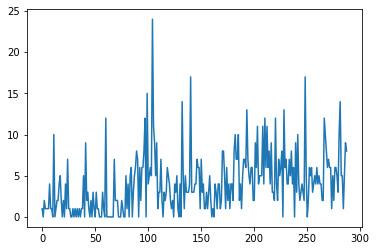

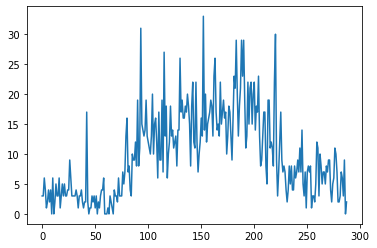

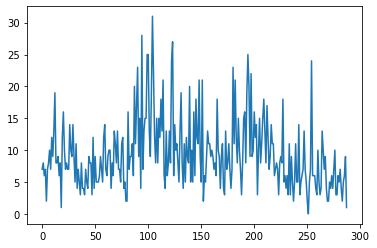

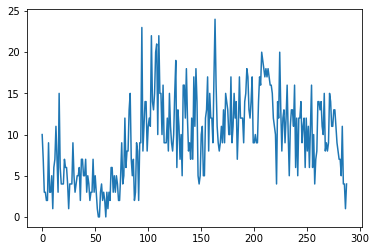

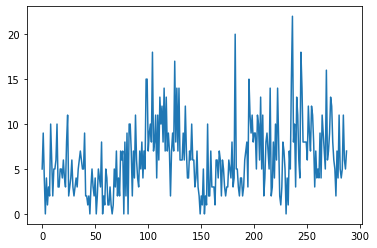

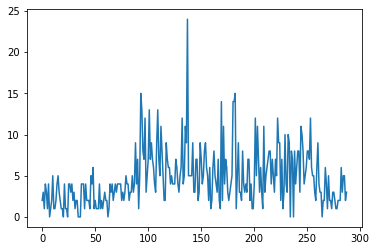

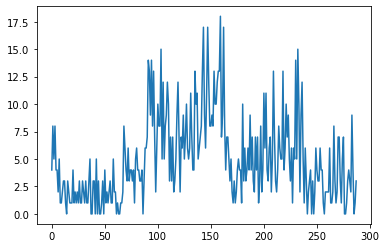

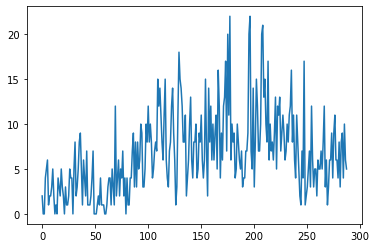

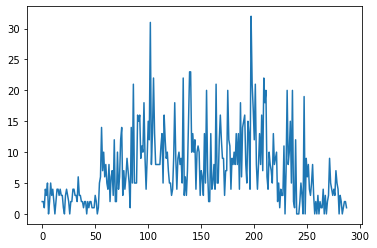

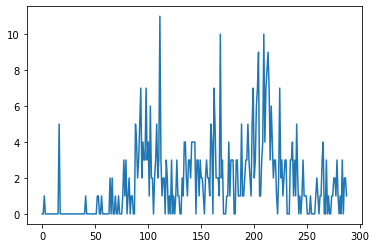

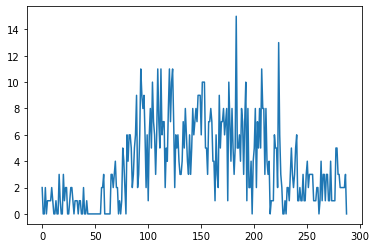

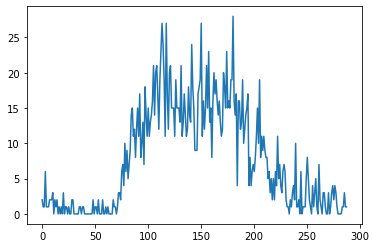

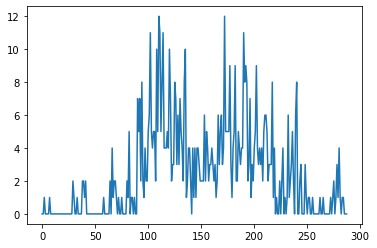

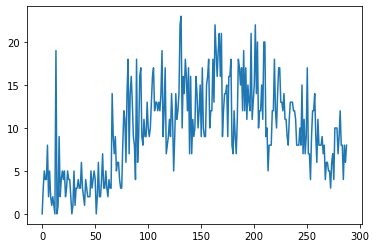

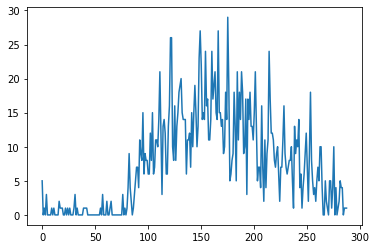

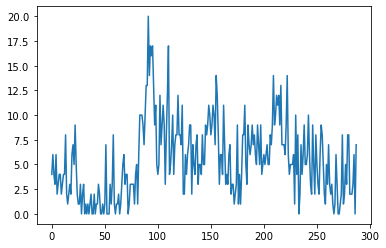

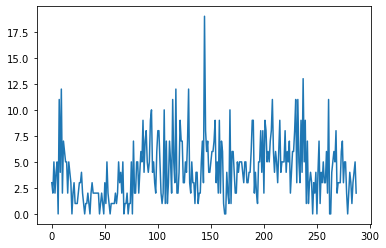

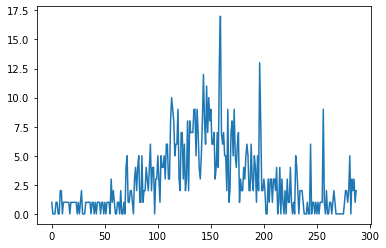

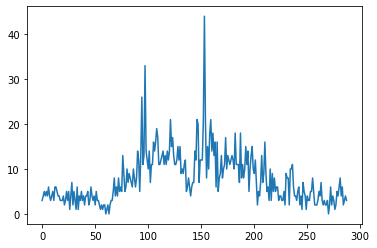

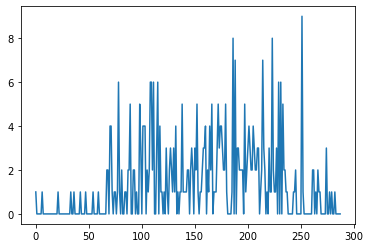

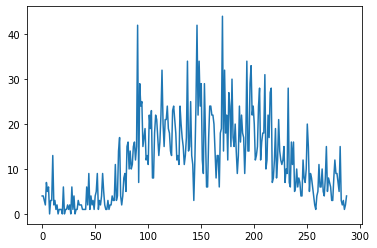

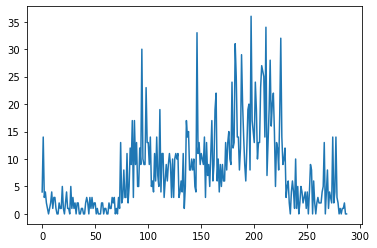

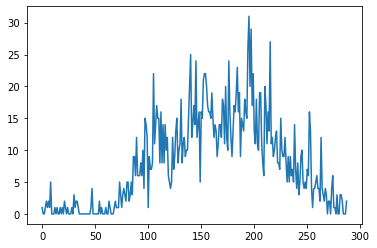

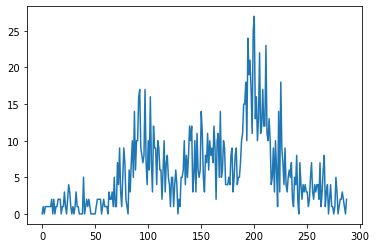

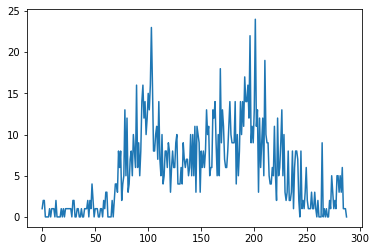

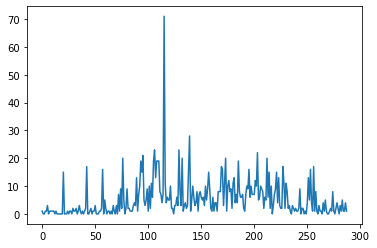

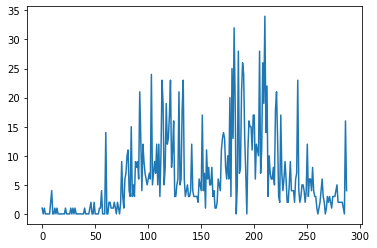

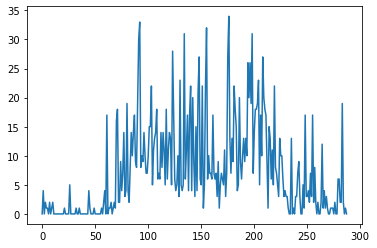

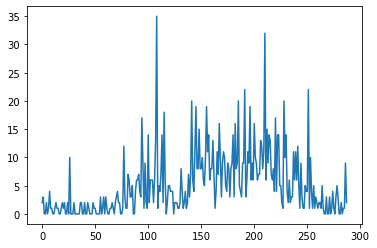

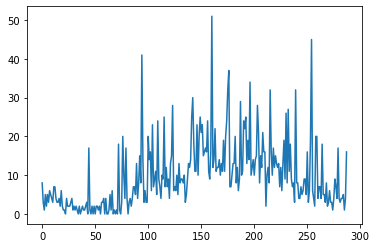

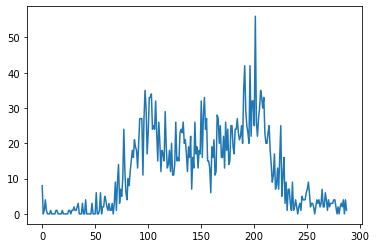

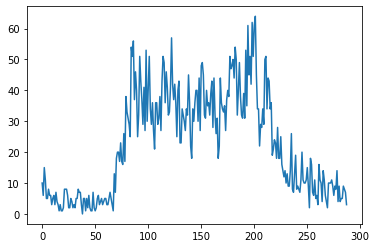

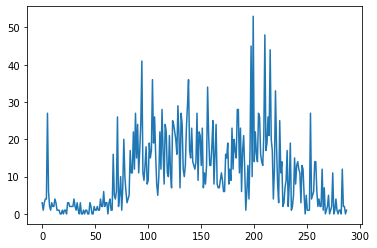

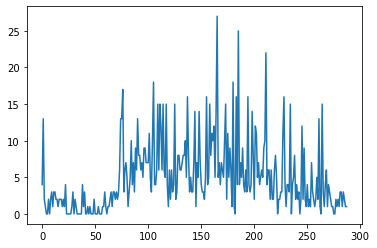

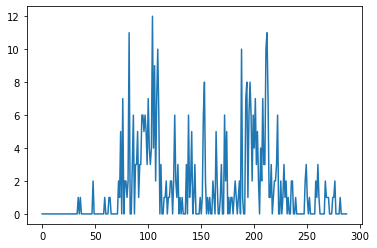

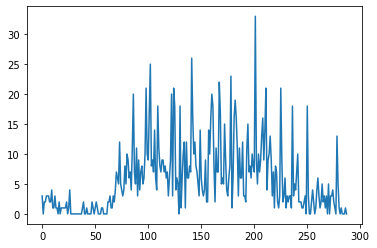

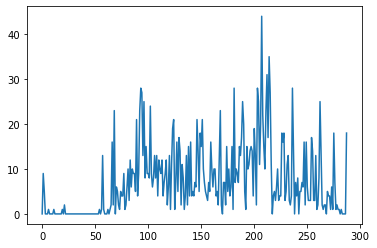

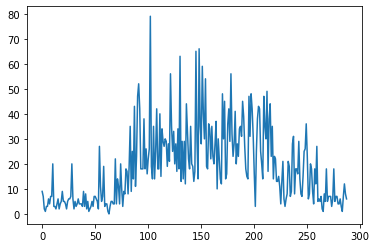

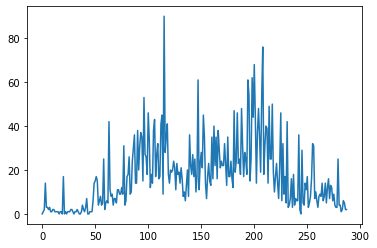

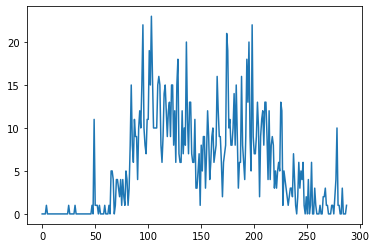

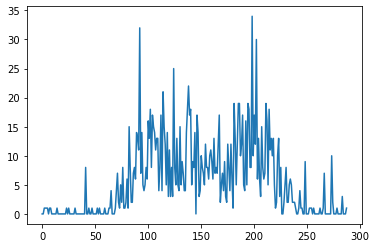

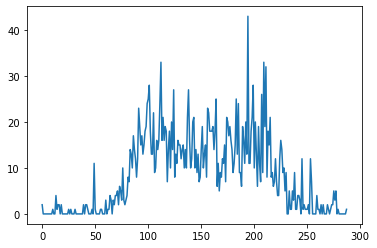

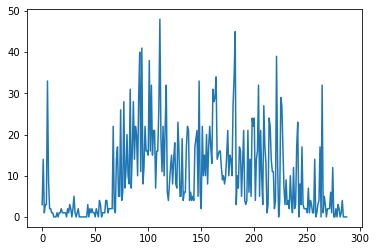

In [12]:
#app-based data based on taz and time 

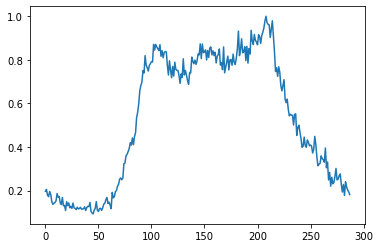

In [13]:
#average obs pattern based on all the taz in the test area (downtown Seattle)